<a href="https://colab.research.google.com/github/szhang06/nlp-classification/blob/main/historical_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 28.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import csv
import glob
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
from keras import backend as K
from tensorflow import keras

import pickle

#### **Data Preparation**

In [ ]:
path = "/content/drive/MyDrive/historical_datasets/data_original"

In [ ]:
text_files = glob.glob(path + "/**/*.txt", recursive = True)
print(text_files)

['/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_8.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_31.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_15.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_38.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_13.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_33.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_19.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_34.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_14.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampeter_22.txt', '/content/drive/MyDrive/historical_datasets/data_original/lampeter_tracts/lampet

In [ ]:
text_label = []
for f in text_files:
  label = f.split("/")[-2].split("_")[-1][:-1]
  with open(f, "r", encoding="latin-1") as t:
    text = t.read()
    text_label.append((text, label))
print(len(text_label))

1065


In [ ]:
dataset = pd.DataFrame(text_label, columns=["text", "label"])  
dataset.shape

(1065, 2)

In [ ]:
print(dataset["label"].unique())

['tract' 'bible' 'treatise' 'drama' 'let' 'narrative-non-fiction'
 'narrative-fiction']


In [ ]:
dataset["label"] = dataset["label"].map({'tract':0, 'bible':1, 'treatise':2, 'drama':3, 'let':4, 'narrative-non-fiction':5,
 'narrative-fiction':6})

In [ ]:
dataset.to_csv("original_dataset.csv")

#### Imbalanced data: oversampling
- the dataset used for training the models is the original one without being oversampled. 

In [ ]:
dataset["label"].value_counts()

1    649
6    128
0    120
3     74
2     54
5     27
4     13
Name: label, dtype: int64

In [ ]:
dataset_1 = dataset[dataset["label"]==1]

In [ ]:
sample_size = dataset_1.shape[0]
print(sample_size)

649


In [ ]:
dataset_6 = dataset[dataset["label"] == 6].sample(sample_size, replace=True)
print(dataset_6.shape)

(649, 2)


In [ ]:
dataset_5 = dataset[dataset["label"] == 5].sample(sample_size, replace=True)
print(dataset_5.shape)

(649, 2)


In [ ]:
dataset_4 = dataset[dataset["label"] == 4].sample(sample_size, replace=True)
print(dataset_4.shape)

(649, 2)


In [ ]:
dataset_3 = dataset[dataset["label"] == 3].sample(sample_size, replace=True)
print(dataset_3.shape)

(649, 2)


In [ ]:
dataset_2 = dataset[dataset["label"] == 2].sample(sample_size, replace=True)
print(dataset_6.shape)

(649, 2)


In [ ]:
dataset_0 = dataset[dataset["label"] == 0].sample(sample_size, replace=True)
print(dataset_0.shape)

(649, 2)


In [ ]:
sampled_dataset = pd.concat([dataset_0, dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, dataset_6], ignore_index=True, axis = 0)
sampled_dataset.shape

(4543, 2)

In [ ]:
sampled_dataset.to_csv("sampled_dataset.csv")

#### **Naive Bayes Classifier**

In [ ]:
vectorizer = TfidfVectorizer(input = "content", decode_error='ignore', stop_words="english")
X = vectorizer.fit_transform(dataset.text.values)
print(vectorizer.get_feature_names_out())
print(X.shape)

(1065, 208408)


In [ ]:
data_indices = np.arange(X.shape[0])

In [ ]:
x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(X, dataset["label"], data_indices, test_size=0.2, random_state=42)
x_validate, x_test, y_validate, y_test, indices_validate, indices_test = train_test_split(x_test,  y_test, indices_test, test_size=0.5, random_state=42)

In [ ]:
param_grid_nb = {
    'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False]
}

In [ ]:
clf_nb = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid_nb, verbose=1, cv=5, n_jobs=-1)
clf_nb.fit(x_train, y_train)
print(clf_nb.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
MultinomialNB(alpha=0.5, fit_prior=False)


In [ ]:
y_pred_nb = clf_nb.predict(x_test)

In [ ]:
clf_nb.score(x_test, y_test)

0.8878504672897196

In [ ]:
print(metrics.classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.99      1.00      0.99        75
           2       1.00      0.40      0.57         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.52      1.00      0.69        11

    accuracy                           0.89       107
   macro avg       0.48      0.45      0.44       107
weighted avg       0.87      0.89      0.86       107



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


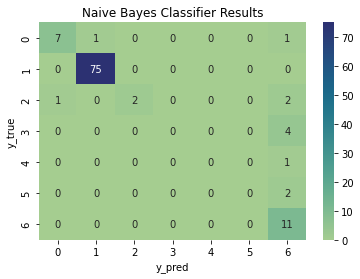

In [ ]:
labels = [0, 1, 2, 3, 4, 5, 6]

cm = confusion_matrix(y_test, y_pred_nb, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

ax = sn.heatmap(df_cm, annot=True, fmt='d', cmap="crest")
ax.set(xlabel="y_pred", ylabel="y_true")
ax.set_title("Naive Bayes Classifier Results")
plt.show()

#### **Support Vector Machine**

In [ ]:
parameters_svm = {'kernel':('linear', 'poly', 'rbf'), 'C':[0.1,1,8,16]}
svc = svm.SVC()
clf_svm = GridSearchCV(svc, parameters_svm, cv=5)
clf_svm.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 8, 16],
                         'kernel': ('linear', 'poly', 'rbf')})

In [ ]:
y_pred_svm = clf_svm.predict(x_test)

In [ ]:
clf_svm.score(x_test, y_test)

0.9719626168224299

In [ ]:
print(metrics.classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00         5
           3       0.80      1.00      0.89         4
           4       0.00      0.00      0.00         1
           5       0.50      0.50      0.50         2
           6       0.91      0.91      0.91        11

    accuracy                           0.97       107
   macro avg       0.74      0.77      0.76       107
weighted avg       0.96      0.97      0.97       107



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


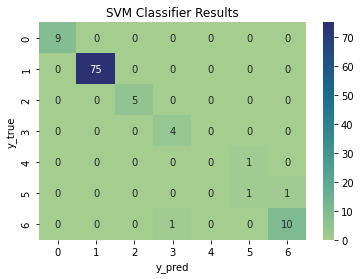

In [ ]:
labels = [0, 1, 2, 3, 4, 5, 6]

cm = confusion_matrix(y_test, y_pred_svm, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

ax = sn.heatmap(df_cm, annot=True, fmt='d', cmap="crest")
ax.set(xlabel="y_pred", ylabel="y_true")
ax.set_title("SVM Classifier Results")
plt.show()

In [ ]:
print(clf_svm.best_estimator_)

SVC(C=8, kernel='linear')


#### **Bert classifier**

##### Data preparation

In [ ]:
num_classes = len(dataset["label"].value_counts())
print(num_classes)

7


In [ ]:
# data split: 8:1:1
x_train, x_validate, x_test = dataset["text"].filter(items = indices_train, axis=0), dataset["text"].filter(items = indices_validate, axis=0), dataset["text"].filter(items = indices_test, axis=0)
y_train, y_validate, y_test = dataset["label"].filter(items = indices_train, axis=0), dataset["label"].filter(items = indices_validate, axis=0), dataset["label"].filter(items = indices_test, axis=0)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train.values, num_classes=num_classes) # [1. 0. 0. 0. 0. 0. 0.]
y_validate = tf.keras.utils.to_categorical(y_validate.values, num_classes=num_classes) # [1. 0. 0. 0. 0. 0. 0.]
y_test = tf.keras.utils.to_categorical(y_test.values, num_classes=num_classes)


In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name = "bert_encodder")


##### Build the model

In [ ]:
def build_classifier_model():
  preprocessing_layer = preprocessor
  encoder_inputs = preprocessing_layer(text_input)
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  # net layers below
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

##### Create f1-score for comparison

In [ ]:
def recall(y_true, y_pred):
    recall_by_class = 0
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def precision(y_true, y_pred):
    precision_by_class = 0
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    return precision_by_class / y_pred.shape[1]

def f1_score(y_true, y_pred):
    Precision = precision(y_true, y_pred)
    Recall = recall(y_true, y_pred)
    return 2 * ((Precision * Recall) / (Precision + Recall + K.epsilon()))


##### Model training



In [ ]:
# loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      recall,
      precision,
      f1_score
]


In [ ]:
n_epochs = 25
# earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      # patience = 3,
                                                      # restore_best_weights = True)

classifier_model.compile(optimizer = "adam",
              loss = loss,
              metrics = metrics)

model_fit = classifier_model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_validate, y_validate),
                      # callbacks = [earlystop_callback]
                      )

Epoch 1/25
27/27 [==============================] - 567s 21s/step - loss: 1.3923 - accuracy: 0.5716 - recall: 0.1160 - precision: 0.1083 - f1_score: 0.1083 - val_loss: 1.1335 - val_accuracy: 0.5472 - val_recall: 0.1369 - val_precision: 0.0953 - val_f1_score: 0.1122
Epoch 2/25
27/27 [==============================] - 553s 21s/step - loss: 1.0507 - accuracy: 0.6455 - recall: 0.1440 - precision: 0.1480 - f1_score: 0.1432 - val_loss: 1.0251 - val_accuracy: 0.6132 - val_recall: 0.1369 - val_precision: 0.1052 - val_f1_score: 0.1189
Epoch 3/25
27/27 [==============================] - 552s 21s/step - loss: 0.9113 - accuracy: 0.6925 - recall: 0.1527 - precision: 0.1658 - f1_score: 0.1567 - val_loss: 0.9066 - val_accuracy: 0.6321 - val_recall: 0.1441 - val_precision: 0.1476 - val_f1_score: 0.1430
Epoch 4/25
27/27 [==============================] - 553s 21s/step - loss: 0.8341 - accuracy: 0.7324 - recall: 0.1797 - precision: 0.2135 - f1_score: 0.1912 - val_loss: 0.8581 - val_accuracy: 0.7170 - va

##### Plot training results

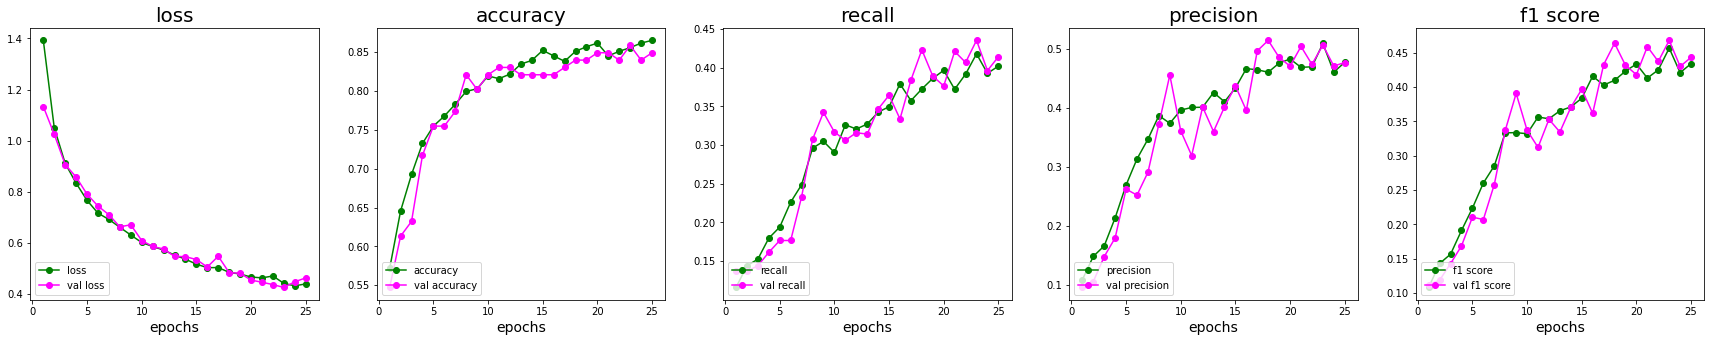

In [ ]:
import matplotlib.pyplot as plt
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "), color="g")
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "), color="magenta")
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

##### Save the model

In [ ]:
model_name = 'model'
saved_model_path = './{}_bert'.format(model_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)


##### Load the model

In [ ]:
loaded_model = keras.models.load_model(saved_model_path,  custom_objects={'precision': precision, 'recall': recall, 'f1_score':f1_score})


##### Predict

In [ ]:
y_pred_bert = [np.argmax(pred) for pred in classifier_model.predict(x_test)]
y_test = [np.argmax(y) for y in y_test]
print(classification_report(y_test, y_pred_bert))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       1.00      1.00      1.00        75
           2       0.80      0.80      0.80         5
           3       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.67      0.91      0.77        11

    accuracy                           0.92       107
   macro avg       0.60      0.55      0.54       107
weighted avg       0.91      0.92      0.90       107



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Confusion matrix

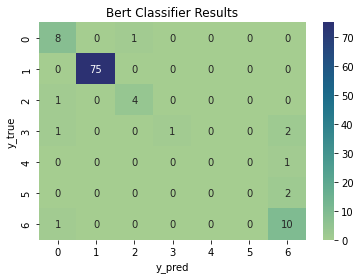

In [ ]:
labels = [0, 1, 2, 3, 4, 5, 6]

cm = confusion_matrix(y_test, y_pred_bert, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

ax = sn.heatmap(df_cm, annot=True, fmt='d', cmap="crest")
ax.set(xlabel="y_pred", ylabel="y_true")
ax.set_title("Bert Classifier Results")
plt.show()